In [3]:
# !pip install lifelines

In [12]:
'''BASIC'''
import numpy as np
import pandas as pd
import random as rand
import datetime
import math
import os
import itertools as itr
import warnings
warnings.simplefilter('ignore')
'''PLOT'''
import seaborn as sns
sns.set(style="ticks", color_codes=True)
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix

plt.style.use('ggplot')
font = {'size':16}
'''STATS'''
import scipy.stats as scs
import statsmodels.api as sm

from sklearn.model_selection import train_test_split

from lifelines import CoxPHFitter 

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

'''RETURN'''
os.system("say 'loading complete' &");

In [24]:
def churnpipe(file, disp=False, impute=True):
    # read
    X = pd.read_csv('data/'+file)
    # create labels based on usage in the past 30 days
    X['churn_yes'] = (pd.to_datetime(X['last_trip_date']) < pd.to_datetime('2014-06-01')) * 1
    
    X['tenure'] = (pd.to_datetime(X['last_trip_date']) - pd.to_datetime(X['signup_date'])).dt.days
    
    X['luxury_car_user'] = X['luxury_car_user'] * 1
    
    # dummies for null ratings or impute
    if impute == True:
        X['avg_rating_by_driver'].fillna(0, inplace=True)
        X['avg_rating_of_driver'].fillna(0, inplace=True)
    else:
        X['rating_by_driver_missing'] = X['avg_rating_by_driver'].isnull()
        X['rating_of_driver_missing'] = X['avg_rating_of_driver'].isnull()
#         X.drop(['avg_rating_by_driver', 'avg_rating_of_driver'], axis=1, inplace=True)
#     # dummies for categorical variables
#     X = X.join(pd.get_dummies(X['phone'], prefix='phone', prefix_sep='_',drop_first=True, dummy_na=True))
#     X = X.join(pd.get_dummies(X['city'], prefix='city', prefix_sep='_',drop_first=True, dummy_na=True))
    # remove the original variables
    X.drop(['last_trip_date', 'signup_date'], axis=1, inplace=True)
    # printout
    if disp == True:
        print(X.info())
        print(X['churn_yes'].value_counts(normalize=True))
    # output
    
    return X



In [25]:
df = churnpipe('churn_train.csv', impute=True)

In [26]:
df.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,phone,surge_pct,trips_in_first_30_days,luxury_car_user,weekday_pct,churn_yes,tenure
0,6.94,5.0,5.0,1.00,Astapor,Android,0.0,0,0,100.0,1,111
1,8.06,5.0,5.0,1.00,Astapor,Android,0.0,2,1,0.0,1,1
2,21.50,4.0,0.0,1.00,Winterfell,iPhone,0.0,1,1,100.0,1,139
3,9.46,5.0,0.0,2.75,Winterfell,Android,100.0,1,0,100.0,1,1
4,13.77,5.0,0.0,1.00,Winterfell,iPhone,0.0,0,0,100.0,1,102


In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 12 columns):
avg_dist                  40000 non-null float64
avg_rating_by_driver      40000 non-null float64
avg_rating_of_driver      40000 non-null float64
avg_surge                 40000 non-null float64
city                      40000 non-null object
phone                     39681 non-null object
surge_pct                 40000 non-null float64
trips_in_first_30_days    40000 non-null int64
luxury_car_user           40000 non-null int64
weekday_pct               40000 non-null float64
churn_yes                 40000 non-null int64
tenure                    40000 non-null int64
dtypes: float64(6), int64(4), object(2)
memory usage: 3.7+ MB


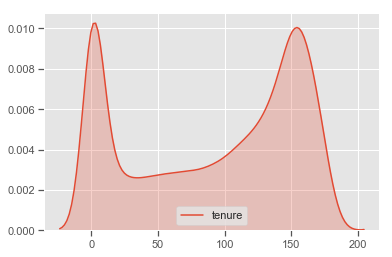

In [28]:
sns.kdeplot(df['tenure'],shade=True);

In [ ]:
sns.pairplot(df,hue='churn_yes');

In [65]:
cph_train, cph_test = train_test_split(df, test_size=0.2) 
cph = CoxPHFitter(penalizer=0.5)
cph.fit(cph_train, duration_col='tenure', event_col='churn_yes',show_progress=True)

ConvergenceError: Convergence halted due to matrix inversion problems. Suspicion is high collinearity. Please see the following tips in the lifelines documentation:
https://lifelines.readthedocs.io/en/latest/Examples.html#problems-with-convergence-in-the-cox-proportional-hazard-model
Matrix is singular.